# The setup

* You are a data scientist at a luxury jelly e-commerce retailer. In hopes of generating a recurring revenue stream, the retailer has decided to roll out a “Jelly of the Month Club.”
* The retailer is testing whether introducing a testimonial from Clark Griswold on the sidebar of the webpage will increase conversions to the Jelly of the Month Club.
* We will also test to see if, during the experiment, purchase amount increased due to the sidebar testimonial.

<img src='https://i0.wp.com/scng-dash.digitalfirstmedia.com/wp-content/uploads/2019/11/LDN-L-CHEVYCHASE-1124-02.jpg?fit=620%2C9999px&ssl=1' width='20%'>
<center>"I love this luxury jelly" - Clark Griswold... prolly</center>

## Read/inspect the data

Also define our handy 95% confidence interval function for later use.

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.proportion as proportion
from statsmodels.stats.weightstats import CompareMeans
import matplotlib.pyplot as plt

%matplotlib inline


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.std() ** 2 / len(x1) + x2.std() ** 2 / len(x2))

    ci_lower_bound = signal - 1.96 * noise
    ci_upper_bound = signal + 1.96 * noise

    return (ci_lower_bound, ci_upper_bound)


# Below package is needed for pandas.read_excel()
# !pip3 install xlrd
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/a-b-testing-drill-start-06-14-19.xlsx"
df = pd.read_excel(data_url)
df.head()

,trans_id,group,cart_amount,convert
0,176890,treatment,49.46,1
1,443058,treatment,49.34,1
2,827633,treatment,44.08,1
3,277331,treatment,47.16,1
4,843324,treatment,44.19,1


<IPython.core.display.Javascript object>

## Test for treatment's effect on `'cart_amount'`

For our analysis, let's separate the 2 groups into 2 separate DataFrames.  Do this filtering below.

In [4]:
treatment = df[df["group"] == "treatment"]
control = df[df["group"] == "control"]

<IPython.core.display.Javascript object>

Control:
DescribeResult(nobs=846, minmax=(37.11, 53.88), mean=45.76147754137116, variance=6.353660654524599, skewness=-0.03752723142075534, kurtosis=0.07031665647793384)

Treatment:
DescribeResult(nobs=934, minmax=(38.79, 53.33), mean=46.08156316916488, variance=4.914859933304416, skewness=0.07382464824639066, kurtosis=-0.07806866468127271)


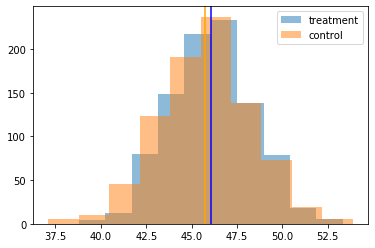

<IPython.core.display.Javascript object>

In [64]:
# Assumptions
# Continuous? yep
# Independent? think so
# Random sample? think so
# Reasonably large? yep
# Normal? yep
print("Control:")
print(stats.describe(control["cart_amount"]))

print("\nTreatment:")
print(stats.describe(treatment["cart_amount"]))

plt.hist(treatment["cart_amount"], alpha=0.5, label="treatment")
plt.hist(control["cart_amount"], alpha=0.5, label="control")
plt.axvline(treatment["cart_amount"].mean(), c="blue")
plt.axvline(control["cart_amount"].mean(), c="orange")
plt.legend()
plt.show()

### Using `scipy.stats.ttest_ind`

Perform a t-test below using `stats.ttest_ind`.

* What are the hypotheses?
* What are the conclusions?
* Calculate a 95% confidence interval.

In [69]:
test_statistic, p_value = stats.ttest_ind(
    treatment["cart_amount"], control["cart_amount"]
)
ci_lo, ci_hi = get_95_ci(treatment["cart_amount"], control["cart_amount"])

<IPython.core.display.Javascript object>

### Using `statsmodels.stats.weightstats.CompareMeans`

As, with everything in python, we have multiple options on how to do anything.  The `statsmodels` package is another option for performing t-tests and calculating confidence intervals.

Perform a t-test below using `statsmodels.stats.weightstats.CompareMeans` (this is already imported as `CompareMeans`)

* What are the conclusions?
* Calculate a 95% confidence interval using the resulting object.

In [73]:
t_test = CompareMeans.from_data(treatment["cart_amount"], control["cart_amount"])
ci_lo, ci_hi = t_test.tconfint_diff(alpha=0.5)

print(t_test.summary())
(ci_lo, ci_hi)

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.3201      0.112      2.850      0.004       0.100       0.540


(0.24432258305862492, 0.3958486725288503)

<IPython.core.display.Javascript object>

## Test for treatment's effect on `'convert'`

Control:
DescribeResult(nobs=846, minmax=(0, 1), mean=0.04964539007092199, variance=0.047236560493516315, skewness=4.1466969926469535, kurtosis=15.19509594882729)

Treatment:
DescribeResult(nobs=934, minmax=(0, 1), mean=0.05353319057815846, variance=0.05072169396687257, skewness=3.966933461248478, kurtosis=13.736561085972838)


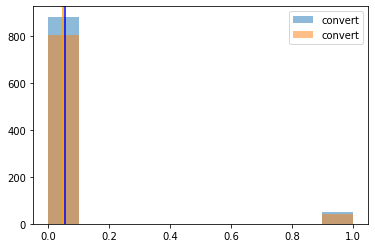

<IPython.core.display.Javascript object>

In [74]:
# Assumptions
# Continuous? nah
# Independent? think so
# Random sample? think so
# Reasonably large? yep
# Normal? nah
print("Control:")
print(stats.describe(control["convert"]))

print("\nTreatment:")
print(stats.describe(treatment["convert"]))

plt.hist(treatment["convert"], alpha=0.5, label="convert")
plt.hist(control["convert"], alpha=0.5, label="convert")
plt.axvline(treatment["convert"].mean(), c="blue")
plt.axvline(control["convert"].mean(), c="orange")
plt.legend()
plt.show()

We failed to meet the assumptions.  There's another test we can do that was mentioned in the reading.


From the reading:
> Because the sample is a proportion, we know more about their distributions than the t-test assumes. Specifically, the distribution of the mean is normal, meaning we could use something called a two sample proportional z-test. We haven't covered this test yet, but you can read about it [here](https://newonlinecourses.science.psu.edu/stat414/node/268/). Find a python implementation for this test and go back and revise our testing. What difference does our new test make?

We'll use [`proportions_ztest`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) from `statsmodels`.  Below is a snippet from the documentation.

> ```
> Parameters
> ----------
> count : integer or array_like
>     the number of successes in nobs trials. If this is array_like, then
>     the assumption is that this represents the number of successes for
>     each independent sample
> nobs : integer or array-like
>     the number of trials or observations, with the same length as
>     count.
> ```

Our hypotheses are listed below:

* $H_o$: The 2 proportions are the same
* $H_a$: The 2 proportions are not the same

What proportions?

We'll take the proportions of num_converted / total for each group.  One way we can find these numbers is using `pd.crosstab`.

In [14]:
crosstab = pd.crosstab(df["group"], df["convert"], margins=True)
crosstab

convert,0,1,All
group,,,
control,804,42,846
treatment,884,50,934
All,1688,92,1780


<IPython.core.display.Javascript object>

The `proportions_ztest()` function takes 2 arguments of interest.  These are `count` & `nobs`.

* For `count` we want the first 2 rows of the column `1`.
* For `nobs` we want the first 2 rows of the column `'All'`.

Perform the needed subsetting of the crosstab below:

In [53]:
count = crosstab.loc[["control", "treatment"], 1]
nobs = crosstab.loc[["control", "treatment"], "All"]

print(count)
print("\n-----------------------\n")
print(nobs)

group
control      42
treatment    50
Name: 1, dtype: int64

-----------------------

group
control      846
treatment    934
Name: All, dtype: int64


<IPython.core.display.Javascript object>

Run the `proportions_ztest`.  What do we conclude in reference to our hypotheses?

In [54]:
z, p_value = proportion.proportions_ztest(count=count, nobs=nobs)
p_value

0.7113883723113998

<IPython.core.display.Javascript object>

More on proportions z-test:

* [Nice intro walkthrough](https://www.youtube.com/watch?v=_58qBy9Uxks)
* ["Use and misuse"](https://influentialpoints.com/Training/z-test_for_independent_proportions_use_and_misuse.htm)
* [Python walkthrough](http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions)

Another potential test is [`proportions_chisquare`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_chisquare.html) from `statsmodels`.  It takes the same arguments.  Below is an excerpt of documentation from `proportions_ztest`.

> In the one and two sample cases with two-sided alternative, this test produces the same p-value as proportions_chisquare, since the chisquare is the distribution of the square of a standard normal distribution.

So in this case, these 2 functions should function the same.

In [56]:
chi2, p_value, expected = proportion.proportions_chisquare(count=count, nobs=nobs)
p_value

0.7113883723113994

<IPython.core.display.Javascript object>

Below slide from [lecture slides for psych10 at Stanford](https://web.stanford.edu/class/psych10/schedule/P10_W7L1)

<img src='https://i.imgur.com/PeglqlG.png' width='50%'>

# Let's p-hack!

## First, let's go over the theory behind it

### Sample size and the t statistic

In a t-test, the p value is directly related to t statistic.  As t increases, p decreases.  The definition of t is below.

$$t = \frac{signal}{noise} = \frac{\overline{x}_{1}-\overline{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}}$$

The denominator (aka $noise$) is the component that is affected by sample size.  The intuition behind this is that as your sample increases you should be drowning out the 'noisy' observations and the result is less noise overall.

This means as as `n` increases, our denominator decreases.  In fractions/division, when we hold the numerator constant and the denominator gets smaller, the result gets larger (e.g. $\frac{1}{4} = 0.25$ & $\frac{1}{2} = 0.5$).

All of this builds up to... our t statistic will get larger as `n` increases (assuming everything else stays relatively the same).

In [62]:
plot = False
np.random.seed(42)

mean_x1 = 11
mean_x2 = 10
std_x1 = 2
std_x2 = 2

ns = [10, 50, 100, 500, 1000, 5000]
for n in ns:
    signal = mean_x1 - mean_x2
    noise = np.sqrt(std_x1 / n + std_x2 / n)

    t = signal / noise
    p = stats.t.sf(np.abs(t), 2 * n - 2) * 2

    # Formatting for {n:5} signifies fixed width of 5
    # Formatting for {t:5.2f} signifies fixed width of 5 and show 2 decimal places
    # See this resource for more on formatting: http://zetcode.com/python/fstring/
    print(f"For n={n:5}, t is {t:5.2f}, p is {p:5.5f}")

    if plot:
        # Adding samples with corresponding loc/scale
        # The sample mean's will vary from the actual
        # ones used in the ttest
        # The mean being tests
        sample_1 = np.random.normal(mean_x1, std_x1, n)
        sample_2 = np.random.normal(mean_x1, std_x1, n)

        # Plot samples with lines for mean as is
        plt.hist(sample_1, alpha=0.5, bins=10, fill="blue")
        plt.hist(sample_2, alpha=0.5, bins=10, fill="orange")
        plt.axvline(sample_1.mean(), c="blue", ls="--", label="actual mean sample x1")
        plt.axvline(sample_2.mean(), c="orange", ls="--", label="actual mean sample x2")

        # Add lines for mean used in ttest
        plt.axvline(mean_x1, c="blue", label="mean x1 in ttest")
        plt.axvline(mean_x2, c="orange", label="mean x2 in ttest")
        plt.legend(loc="upper right")
        plt.show()

For n=   10, t is  1.58, p is 0.13126
For n=   50, t is  3.54, p is 0.00062
For n=  100, t is  5.00, p is 0.00000
For n=  500, t is 11.18, p is 0.00000
For n= 1000, t is 15.81, p is 0.00000
For n= 5000, t is 35.36, p is 0.00000


<IPython.core.display.Javascript object>

### Sample size and the confidence interval

The formula for a 95% confidence interval for our t-test is shown below.  Reason out what will happen to our confidence interval as sample size increases.

$$\overline{X}_{1}-\overline{X}_{2} \pm 1.96 * {\sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}}$$

For n=   10, CI is (-0.24,  2.24)
For n=   50, CI is ( 0.45,  1.55)
For n=  100, CI is ( 0.61,  1.39)
For n=  500, CI is ( 0.82,  1.18)
For n= 1000, CI is ( 0.88,  1.12)
For n= 5000, CI is ( 0.94,  1.06)


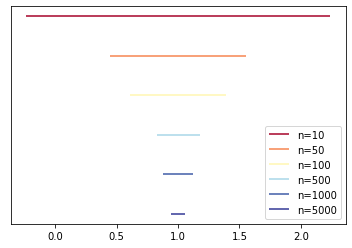

<IPython.core.display.Javascript object>

In [61]:
mean_x1 = 11
mean_x2 = 10
std_x1 = 2
std_x2 = 2

ns = [10, 50, 100, 500, 1000, 5000]
for i, n in enumerate(ns):
    signal = mean_x1 - mean_x2
    noise = np.sqrt(std_x1 / n + std_x2 / n)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    # Formatting for {n:5} signifies fixed width of 5
    # Formatting for {ci_lo:5.2f} signifies fixed width of 5 and show 2 decimal places
    # Formatting for {ci_hi:5.2f} signifies fixed width of 5 and show 2 decimal places
    # See this resource for more on formatting: http://zetcode.com/python/fstring/
    print(f"For n={n:5}, CI is ({ci_lo:5.2f}, {ci_hi:5.2f})")

    color = plt.cm.RdYlBu(i * 60)
    plt.hlines(len(ns) - i, ci_lo, ci_hi, colors=[color], label=f"n={n}")

plt.yticks([])
plt.legend(loc="lower right")
plt.show()